In [19]:
"""
If you run this block more than once you will get 88 THOUSAND newlines (in the data)
"""

import json
import numpy as np
import pandas

#this code makes your editing experience using both python files 
#and notebooks a lot easier
%load_ext autoreload
#written to make things easier
%aimport utility 
%autoreload 1

#this is done to avoid the double processing problem
origin_sjc, origin_state_appeals = utility.combine_cases()
all_sjc = origin_sjc.copy(deep=True)
all_state_appeals = origin_state_appeals.copy(deep=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
#returns case numbers and sections in which found within a case
def find_in_text(case_data,phrase):
    cases_found = []
    for case in range(len(case_data)):
        place_found = []
        for i in range(len(case_data[case]["text"])):
            if case_data[case]["text"][i].lower().find(phrase.lower()) != -1:
                place_found.append(i)
        
        if len(place_found) > 0:
            cases_found.append([case,place_found])
    return cases_found

In [21]:
def find_in_headnote(case_data,phrase):
    cases_found = []
    for case in range(len(case_data)):
        place_found = []
        for i in range(len(case_data[case]["headnote"])):
            if case_data[case]["headnote"][i].lower().find(phrase.lower()) != -1:
                place_found.append(i)
        
        if len(place_found) > 0:
            cases_found.append([case,place_found])
    return cases_found

In [22]:
# Searches list_of_keywords in string case_data
# and returns the total number of cases that contained any keyword
#as well as the "case numbers", that is, currently
#line numbers in the file
def number_of_cases_per_keywords(case_data, list_of_keywords):
    all_cases = set()
    for keyword in list_of_keywords:
        all_with_keyword = set()
        all_in_text = find_in_text(case_data, keyword)
        all_in_headnote = find_in_headnote(case_data, keyword)
        for occurence in all_in_text:
            all_with_keyword.add(occurence[0])
        for occurence in all_in_headnote:
            all_with_keyword.add(occurence[0])
        all_cases.update(all_with_keyword)
    pretty = list(all_cases)
    pretty.sort()
    return len(pretty), pretty

In [23]:
def contains(dataframe, *keywords):
    logical_list = dataframe.text.str.contains(keywords[0])
    for i in range(1, len(keywords)):
        logical_list = logical_list | dataframe.text.str.contains(keywords[i])
    return logical_list

#elementwise xor:
#returns true at i if and only if series1[i] and series2[i]
#are different
def logic_xor(series1, series2):
    return (series1 | series2) & ~(series1 & series2)


In [24]:
important_keywords = ["confidential informant", " ci ", "snitch", "informant", "gang informant"]

In [25]:
#we used to have a duplicate row problem


# print("statistics of how we are double counting: values represent how many times an index appears")
# print(all_sjc.index.to_series().value_counts().describe(), "\n\n")

# print("showing you in the other list, max is like half of the whole list (statistics a)")
# print(all_state_appeals.index.to_series().describe(), "\n")

# print("statistics of how bad the problem is in that list")
# print(all_state_appeals.index.to_series().value_counts().describe(), "\n\n")

# print("thus, if you sort things, it looks like this")
# print(all_state_appeals.sort_index()[0:6], "\n")

# print("this leads to the following problem:")


# """
# print("You see this makes things much more reasonable to remove \
# newlines but it also squishes punctuation sometimes:\n")
# print(messed_up.str.replace(pat="\n", repl="").iloc[0][0:500], "...\n")

# print("This is a big problem in the state appeals cases. Statistics for newlines in state appeals:\n",
#       all_state_appeals.text.str.count("\n").describe())

# print("\nNote: there are no newlines in sjc cases: \n", all_sjc.text.str.count("\n").describe(), "\n")

# #so, replace the text column to have it be good
# all_state_appeals.text = all_state_appeals.text.str.replace(pat="\n", repl="")
# """


In [198]:
#Check that some files are ok
#There also used to be a big problem here with newlines

print("An sjc case partial text:")
print(all_sjc.loc[ 0, : ].text[0:300], "...\n\n")

print("A state appeals partial text:")
messed_up = all_state_appeals[1:2].text
print(messed_up.values[0][0:300], "...\n\n")



An sjc case partial text:

The present case is the most recent in a series of cases concerning the egregious misconduct of Annie Dookhan, a chemist who was employed in the forensic drug laboratory of the William A. Hinton State Laboratory Institute (Hinton drug lab) from 2003 until 2012.  On January 23, 2007, the defendant,  ...


A state appeals partial text:

This case arises from the grant of a groundwater discharge permit (permit) to the town of Falmouth (town) for the construction and operation of a wastewater treatment facility (treatment facility) and leach field.
The plaintiffs are abutters to the site of the proposed treatment facility or the pro ...




In [34]:
vacate_indeces = all_sjc.text.str.contains("vacate") | contains(all_sjc,"vacated")


we_affirm = contains(all_sjc, "We affirm", "we affirm")
print("we affirm\n", we_affirm.value_counts())

affirmed_indeces = all_sjc.text.str.contains("affirm") | we_affirm
print("all Affirmed cases:\n", affirmed_indeces.value_counts())


we_reverse = contains(all_sjc, "we reverse") | contains(all_sjc, "We reverse")
print("\nwe reverse\n", we_reverse.value_counts())

reversed_indeces = all_sjc.text.str.contains("reverse") | we_reverse
print("\nall w reversed:\n", reversed_indeces.value_counts())


really_bad = we_affirm & we_reverse

print("\nhas both we affirm and we reverse\n", really_bad.value_counts())

both_reversed_and_affirmed = reversed_indeces & affirmed_indeces
print("\nreversed and affirmed\n", both_reversed_and_affirmed.value_counts())
print(both_reversed_and_affirmed.sort_values())
#print(all_sjc.loc[ 681, : ].text)

print("\nonly one or the other appears:")
print(logic_xor(reversed_indeces, affirmed_indeces).value_counts())

we affirm
 False    1456
True     1199
Name: text, dtype: int64
all Affirmed cases:
 True     2008
False     647
Name: text, dtype: int64

we reverse
 False    2449
True      206
Name: text, dtype: int64

all w reversed:
 False    1924
True      731
Name: text, dtype: int64

has both we affirm and we reverse
 False    2601
True       54
Name: text, dtype: int64

reversed and affirmed
 False    2096
True      559
Name: text, dtype: int64
0       False
1673    False
1674    False
1675    False
1677    False
        ...  
1913     True
1916     True
1918     True
1855     True
1327     True
Name: text, Length: 2655, dtype: bool

only one or the other appears:
True     1621
False    1034
Name: text, dtype: int64


In [35]:
terrible_cases = ~(contains(all_sjc,
    "reverse", "affirm", "vacate", "uphold", "overturn", "disagree", "defer",
                            "reject", "remand", "Appeal dismissed"))
print("Terrible cases we can't deal with, have no keywords:\n", 
         terrible_cases.value_counts(), "\n")

terrible_cases = terrible_cases.sort_values()
print("Classification of some of the cases:\n", terrible_cases,"\n")

print("For example:")
print(all_sjc.loc[ 2500, : ].text, "...\n\n")
    

Terrible cases we can't deal with, have no keywords:
 False    2485
True      170
Name: text, dtype: int64 

Classification of some of the cases:
 0       False
1668    False
1669    False
1670    False
1671    False
        ...  
2530     True
2531     True
2532     True
2507     True
2500     True
Name: text, Length: 2655, dtype: bool 

For example:
INDICTMENTS found and returned in the Superior Court Department on November 2, 2010.
Pretrial motions to suppress evidence were heard by Charles J. Hely, J., and Janet L. Sanders, J., and cases were tried before Linda E. Giles, J.
Jeffrey L. Baler for Alexander Gallett.
Andrew S. Crouch for Michel St. Jean.
Sarah Montgomery Lewis, Assistant District Attorney (Jennifer Hickman, Assistant District Attorney, also present) for the Commonwealth. ...




In [36]:
copy = all_sjc.copy(deep=True)

def add_counts(dataframe, word_list):
    for word in word_list:
        col_name = word+ " count"
        dataframe[col_name] = dataframe.text.str.count(word)
        
        
triggers = ["We affirm", "we affirm", "We reverse", 
            "we reverse", "vacate", "affirm", "reverse", "Appeal dismissed"]
add_counts(copy, triggers)

print(copy)
    
# print(copy["Appeal dismissed count"].value_counts())

                                         case  \
0        COMMONWEALTH  vs.  ADMILSON RESENDE.   
1        COMMONWEALTH  vs.  GEORGE PHILBROOK.   
2      LINDA S. BOWERS  vs.  P. WILE'S, INC.    
3          COMMONWEALTH  vs.  JARED ABDALLAH.   
4          COMMONWEALTH  vs.  ROBERT D. WADE.   
...                                       ...   
2650            IN THE MATTER OF CLAUDE DAVID   
2651                   KAROL E. SIMONTON, pet   
2652                                    A.F.    
2653            IN THE MATTER OF CARL MARTIN    
2654     BHARANIDHARAN PADMANABHAN vs. LORETT   

                                               headnote  \
0     Controlled Substances. Constitutional Law, Ple...   
1     Homicide. Evidence, Prior violent conduct, Sta...   
2     Negligence, Retailer. Notice. Practice, Civil,...   
3     Constitutional Law, Search and seizure. Search...   
4     Amended October 28, 2016\nDeoxyribonucleic Aci...   
...                                                 ...  

In [37]:

#need to look at vacate
def add_status(dataframe):
    
    
    #creating the column
    triggers = ["We affirm", "we affirm", "We reverse", 
            "we reverse", "vacate", "affirm", "reverse", "Appeal dismissed"]
    add_counts(dataframe, triggers)
    dataframe["decision"] = "undecided"
    
    definite_affirm = contains(dataframe, "We affirm", "we affirm")
    definite_reverse = contains(dataframe, "We reverse", "we reverse")
    
    dataframe.decision[definite_reverse] = "reverse"
    dataframe.decision[definite_affirm] = "affirm"
    
    print("After look for\"we\" keyword, we have the following:")
    print(dataframe.decision.value_counts())
        
    
    sort_of_affirm = (dataframe["affirm count"] > 0) & (dataframe.decision == "undecided")
    sort_of_reverse = (dataframe.decision == "undecided") & (dataframe["affirm count"] > 0)
    
    dataframe.decision[sort_of_affirm] = "affirm"
    dataframe.decision[sort_of_reverse] = "reverse"
    
    print("Adding a less strict approach we have the following:")
    print(dataframe.decision.value_counts())
    
    dismissed = (dataframe.decision == "undecided") & (dataframe["Appeal dismissed count"] > 0)
    dataframe.decision[dismissed] = "affirm"
    
    print("With dismissed:")
    print(dataframe.decision.value_counts())
    
#     dataframe.decision[sort_of_affirm] = "affirm"
#     dataframe.decision[sort_of_reverse] = "reverse"
    
#     undecided_still = dataframe.decision.str.contains("undecided")
#     print("Decision was not that conclusive couldn't find any keyword :\n"
#           , undecided_still.value_counts(), "\n")

    
    
    
add_status(copy)


After look for"we" keyword, we have the following:
undecided    1304
affirm       1199
reverse       152
Name: decision, dtype: int64
Adding a less strict approach we have the following:
affirm       1199
reverse       879
undecided     577
Name: decision, dtype: int64
With dismissed:
affirm       1239
reverse       879
undecided     537
Name: decision, dtype: int64


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_lau

### Expanding on our overturned analysis we will perform a logistic regression on the data. 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_lau

After look for"we" keyword, we have the following:
undecided    1304
affirm       1199
reverse       152
Name: decision, dtype: int64
Adding a less strict approach we have the following:
affirm       1199
reverse       879
undecided     577
Name: decision, dtype: int64
With dismissed:
affirm       1239
reverse       879
undecided     537
Name: decision, dtype: int64
After look for"we" keyword, we have the following:
undecided    1922
affirm       1866
reverse       568
Name: decision, dtype: int64
Adding a less strict approach we have the following:
affirm       1866
reverse      1763
undecided     727
Name: decision, dtype: int64
With dismissed:
affirm       1876
reverse      1763
undecided     717
Name: decision, dtype: int64


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(0.5, 1.0, 'Before Logistic Regression')

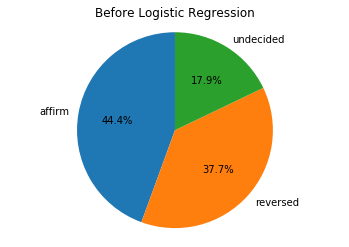

In [264]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# First we do a deep copy of both our sjc and appeals cases and assign as many decisions as we can
copy_sjc = all_sjc.copy(deep=True)
add_status(copy_sjc)
copy_appeals = all_state_appeals.copy(deep=True)
add_status(copy_appeals)

# now we separate all unlabeled data from our dataframe, all undecided cases.
all_cases = copy_sjc.append(copy_appeals)
undecided_cases = all_cases.loc[all_cases["decision"] == "undecided"]
all_cases = all_cases.loc[all_cases["decision"] != "undecided"]

# We change labels to indeces
affirm = (all_cases.decision == "affirm")
all_cases.decision[affirm] = 1
reverse = (all_cases.decision == "reverse")
all_cases.decision[reverse] = 0


# Compile all our text data.
str_txt = []
text = pd.DataFrame(all_cases["text"])
for i in range(len(text.values)):
    str_txt.append(text.values[i][0])

# Vectorize the text data
vectorizer = TfidfVectorizer(stop_words='english',min_df=0.001)
vectorizer = vectorizer.fit(str_txt)
words = vectorizer.get_feature_names()
matrix = vectorizer.transform(str_txt)
pd_matrix = pd.DataFrame(matrix.toarray(),columns=words)

# plot the results in a pie chart
num_affirm = all_cases.loc[all_cases["decision"] == 1]
num_reversed = all_cases.loc[all_cases["decision"] == 0]
num_undec = undecided_cases
plt.pie([len(num_affirm),len(num_reversed),len(num_undec)],labels=["affirm","reversed","undecided"],startangle=90,autopct='%1.1f%%')
plt.axis('equal')
plt.title("Before Logistic Regression")


In [265]:
print(pd_matrix)

       00       000  001  002  003  005  006  007  008  009  ...  zotos  \
0     0.0  0.003021  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
1     0.0  0.006609  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
2     0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
3     0.0  0.008929  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
4     0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
...   ...       ...  ...  ...  ...  ...  ...  ...  ...  ...  ...    ...   
5752  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
5753  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
5754  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
5755  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
5756  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   

      zucco  zuckerman  zukoski  zullo  zuluaga  zurich  zussman  zuzick  zvi  
0       0.0        

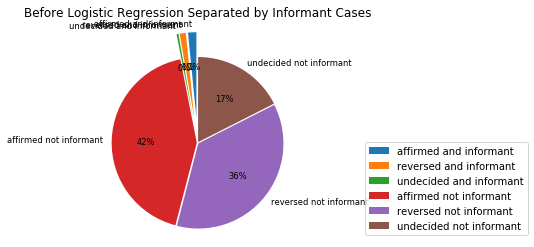

In [195]:
# Relevance to informant search in pie chart
affirm_inform = contains(num_affirm,"confidential informant", " ci ", "snitch", "informant", "gang informant")
affirm_inform = affirm_inform.loc[affirm_inform==True]
reverse_inform = contains(num_reversed,"confidential informant", " ci ", "snitch", "informant", "gang informant")
reverse_inform = reverse_inform.loc[reverse_inform==True]
undec_inform = contains(num_undec,"confidential informant", " ci ", "snitch", "informant", "gang informant")
undec_inform = undec_inform.loc[undec_inform==True]

labels=["affirmed and informant","reversed and informant","undecided and informant","affirmed not informant","reversed not informant","undecided not informant"]
plt.pie([len(affirm_inform),len(reverse_inform),len(undec_inform),len(num_affirm)-len(affirm_inform),len(num_reversed)-len(reverse_inform),len(num_undec)-len(undec_inform)],labels=labels,startangle=90,autopct="%1.0i%%",explode=(0.3, 0.3,0.3, 0.01, 0.01,0.01),textprops={'size': 'small'})
plt.axis('equal')
plt.title("Before Logistic Regression Separated by Informant Cases")
plt.legend(loc='lower right',bbox_to_anchor=(1, 0, 0.5, 1))

Text(0.5, 1.0, 'Before Logistic Regression Informant Cases and their Decisions')

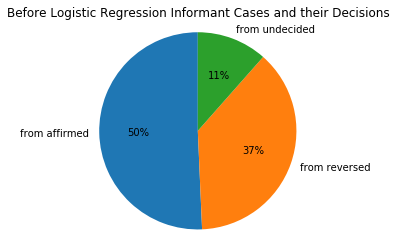

In [196]:
# now for only informant cases, what are their decisions
plt.pie([len(affirm_inform),len(reverse_inform),len(undec_inform)],labels=["from affirmed","from reversed","from undecided"],startangle=90,autopct="%1.0i%%")
plt.axis('equal')
plt.title("Before Logistic Regression Informant Cases and their Decisions")

### Now we do the logistic regression

In [266]:
# Perform Logistic Regression
logreg = LogisticRegression(verbose=1,solver="sag", n_jobs=4).fit(pd_matrix,list(all_cases["decision"]))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 34 epochs took 41 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   40.7s finished


In [267]:
#logistic regression training accuracy 86%
logreg.score(pd_matrix,list(all_cases["decision"]))

0.8412367552544728

In [296]:
# Here we evaluate the relative importance of each word to the prediction of the logistic regression
# The more a word has a negative coefficient, the more important it is for the algorithm to predict it as reversed.
# The more a word has a positive coefficient, the more important it is for the algorithm to predict it as affirmed.
importance = pd.DataFrame(logreg.coef_,columns=pd_matrix.columns)
importance = pd.Series(importance.transpose()[0])
importance = importance.sort_values()
print(importance[:20])
print()
print(importance[-20:])
len(importance)


reversed      -2.491500
reverse       -2.369554
remanded      -1.871203
complainant   -1.644267
ordered       -1.376633
proceedings   -1.359415
question      -1.252139
officer       -1.190199
case          -1.157154
remand        -1.145449
note          -1.139534
williams      -1.124071
appellate     -1.085217
presentment   -1.071989
self          -1.039116
aside         -1.025267
retrial       -1.019293
richard       -0.994006
crab          -0.970109
seller        -0.968076
Name: 0, dtype: float64

failed           0.964407
denying          1.160609
jury             1.162739
denied           1.172361
victim           1.205916
title            1.241139
single           1.251117
contributions    1.278954
abuse            1.303382
33e              1.312791
claim            1.326886
murder           1.349380
argues           1.361432
discretion       1.403535
relief           1.442526
justice          1.456505
claims           1.529959
petition         1.813208
211              2.208358
a

24607

In [197]:
# Now we label the unlabeled data with the model we created
# Starting by vectorizing it
undecided_matrix = vectorizer.transform(undecided_cases["text"].values)
undecided_df = pd.DataFrame(undecided_matrix.toarray())

# And using our model to predict the labels
predictions = logreg.predict(undecided_df)
num1 = sum(predictions)
print(num1)
print(predictions[0:1000])
print(len(undecided_cases))

# After our prediction we reintroduce the undecided cases to the dataset with their prediction. 
undecided_cases["decision"] = predictions
all_cases = all_cases.append(undecided_cases, ignore_index=True)


433
[0 0 0 1 0 1 0 1 0 0 1 1 1 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0
 1 1 0 1 1 0 0 0 0 1 0 1 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 0 1 1 1 1 0 0 1 0 1
 1 0 0 1 0 0 0 1 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 1 1 1 0 1 1 0 1 0 0 0 0 0
 0 1 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1
 1 1 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 1
 0 0 0 0 0 0 0 0 1 0 1 1 0 1 1 0 0 1 0 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 1
 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 0 0 1 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 1 0 0 1
 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0
 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0
 0 0 1 0 0 1 1 0 0 1 0 0 0 1 1 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 

In [47]:
scores = []
num_affirm = [] 
for i in range(1,6):
    vectorizer = TfidfVectorizer(stop_words='english',min_df=(0.1)**i)
    vectorizer = vectorizer.fit(str_txt)
    matrix = vectorizer.transform(str_txt)
    pd_matrix = pd.DataFrame(matrix.toarray())
    
    # Perform Logistic Regression
    logreg = LogisticRegression(verbose=1,solver="sag",n_jobs=4).fit(pd_matrix,list(all_cases["decision"]))
    
    #logistic regression training accuracy%
    scores.append(logreg.score(pd_matrix,list(all_cases["decision"])))
    
    # Now we label the unlabeled data with the model we created
    # Starting by vectorizing it
    undecided_matrix = vectorizer.transform(undecided_cases["text"].values)
    undecided_df = pd.DataFrame(undecided_matrix.toarray())

    # And using our model to predict the labels
    predictions = logreg.predict(undecided_df)
    num1 = sum(predictions)
    num_affirm.append(num1)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 27 epochs took 3 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 30 epochs took 15 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   15.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 34 epochs took 47 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   46.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 35 epochs took 167 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  2.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 30 epochs took 141 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  2.3min finished


Text(0.5, 1.0, 'Training Accuracy with multiple vectorizations')

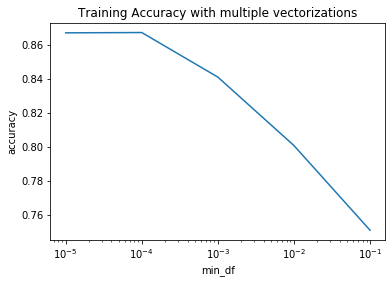

In [50]:
import matplotlib.pyplot as plt
x = 0.1**np.asarray(range(1,6))
plt.semilogx(x,scores)
plt.xlabel("min_df")
plt.ylabel("accuracy")
plt.title("Training Accuracy with multiple vectorizations")

Text(0.5, 1.0, 'Percentage of affirmed cases with multiple vectorizations')

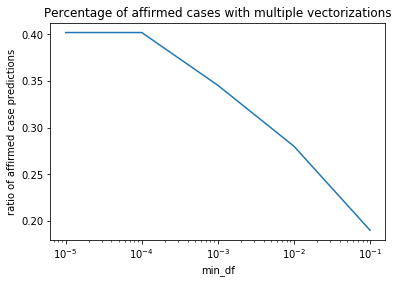

In [51]:
x = 0.1**np.asarray(range(1,6))
plt.semilogx(x,np.asarray(num_affirm)/len(predictions))
plt.xlabel("min_df")
plt.ylabel("ratio of affirmed case predictions")
plt.title("Percentage of affirmed cases with multiple vectorizations")

Text(0.5, 1.0, 'After Logistic Regression')

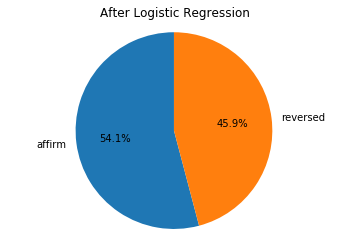

In [128]:
num_affirm = all_cases.loc[all_cases["decision"] == 1]
num_reversed = all_cases.loc[all_cases["decision"] == 0]
plt.pie([len(num_affirm),len(num_reversed)],labels=["affirm","reversed"],startangle=90,autopct='%1.1f%%')
plt.axis('equal')
plt.title("After Logistic Regression")


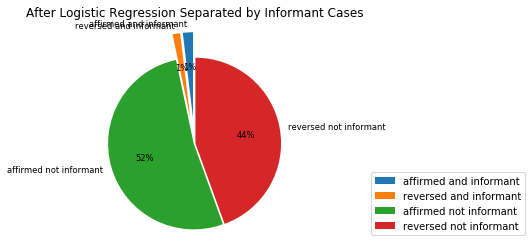

In [182]:
important_keywords = ["confidential informant", " ci ", "snitch", "informant", "gang informant"]
affirm_inform = contains(num_affirm,"confidential informant", " ci ", "snitch", "informant", "gang informant")
affirm_inform = affirm_inform.loc[affirm_inform==True]
reverse_inform = contains(num_reversed,"confidential informant", " ci ", "snitch", "informant", "gang informant")
reverse_inform = reverse_inform.loc[reverse_inform==True]
labels=["affirmed and informant","reversed and informant","affirmed not informant","reversed not informant"]
plt.pie([len(affirm_inform),len(reverse_inform),len(num_affirm)-len(affirm_inform),len(num_reversed)-len(reverse_inform)],labels=labels,startangle=90,autopct="%1.0i%%",explode=(0.3, 0.3, 0.01, 0.01),textprops={'size': 'small'})
plt.axis('equal')
plt.title("After Logistic Regression Separated by Informant Cases")
plt.legend(loc='lower right',bbox_to_anchor=(1, 0, 0.5, 1))


Text(0.5, 1.0, 'After Logistic Regression Informant Cases and their Decisions')

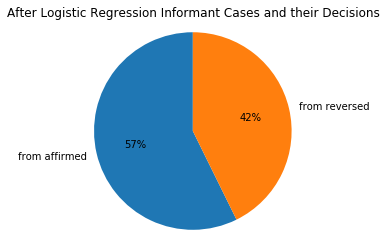

In [192]:
plt.pie([len(affirm_inform),len(reverse_inform)],labels=["from affirmed","from reversed"],startangle=90,autopct="%1.0i%%")
plt.axis('equal')
plt.title("After Logistic Regression Informant Cases and their Decisions")

### searching for total number (using all_cases now)

In [68]:
print("total number of cases was: ",len(all_sjc) +len(all_state_appeals) )

total number of cases was:  7011


In [72]:
result = len(number_of_cases_per_keywords(all_sjc,important_keywords)) + len(number_of_cases_per_keywords(all_state_appeals,important_keywords))
print(result)

KeyError: 0

In [67]:
important_keywords.remove("informant")
print(number_of_cases_per_keywords(all_sjc, important_keywords)[0] + number_of_cases_per_keywords(all_state_appeals, important_keywords)[0])

NameError: name 'cases' is not defined

### Searching terms in text then headnote for cases.csv

In [ ]:
print(find_in_text(cases,"confidential informant"))

In [ ]:
print(find_in_headnote(cases,"confidential informant"))

In [ ]:
print(find_in_text(cases," ci "))

In [ ]:
print(find_in_headnote(cases," ci "))

In [ ]:
print(find_in_text(cases,"snitch"))

In [ ]:
print(find_in_headnote(cases,"snitch"))

In [ ]:
print(find_in_text(cases,"informant"))

In [ ]:
print(find_in_headnote(cases,"informant"))

In [ ]:
print(find_in_text(cases,"gang informant"))

In [ ]:
print(find_in_headnote(cases,"gang informant"))

In [ ]:
print(find_in_text(cases,"mafia informant"))

In [ ]:
print(find_in_headnote(cases,"mafia informant"))

In [ ]:
print(find_in_text(cases,"organized crime informant"))

In [ ]:
print(find_in_headnote(cases,"organized crime informant"))

In [ ]:
print(find_in_text(cases,"Stephen Lynch informant"))

In [ ]:
print(find_in_headnote(cases,"Stephen Lynch informant"))

In [ ]:
print(find_in_text(cases,"federal prison informant"))

In [ ]:
print(find_in_headnote(cases,"federal prison informant"))

In [ ]:
print(find_in_text(cases,"prison informant"))

In [ ]:
print(find_in_headnote(cases,"prison informant"))

In [ ]:
print(find_in_text(cases,"Whitey Bulger informant"))

In [ ]:
print(find_in_headnote(cases,"Whitey Bulger informant"))

In [ ]:
print(find_in_text(cases,"U.S. government informant"))

In [ ]:
print(find_in_headnote(cases,"U.S. government informant"))

In [ ]:
print(find_in_text(cases,"government informant"))

In [ ]:
print(find_in_headnote(cases,"government informant"))

In [ ]:
print(find_in_text(cases,"government snitch"))

In [ ]:
print(find_in_headnote(cases,"government snitch"))

### Searching terms in text then headnote for cases_appeals.csv

In [ ]:
print(find_in_text(appeals,"confidential informant"))

In [ ]:
print(find_in_headnote(appeals,"confidential informant"))

In [ ]:
print(find_in_text(appeals," ci "))

In [ ]:
print(find_in_headnote(appeals," ci "))

In [ ]:
print(find_in_text(appeals,"snitch"))

In [ ]:
print(find_in_headnote(appeals,"snitch"))

In [ ]:
print(find_in_text(appeals,"informant"))

In [ ]:
print(find_in_headnote(appeals,"informant"))

In [ ]:
print(find_in_text(appeals,"gang informant"))

In [ ]:
print(find_in_headnote(appeals,"gang informant"))

In [ ]:
print(find_in_text(appeals,"mafia informant"))

In [ ]:
print(find_in_headnote(appeals,"mafia informant"))

In [ ]:
print(find_in_text(appeals,"organized crime informant"))

In [ ]:
print(find_in_headnote(appeals,"organized crime informant"))

In [ ]:
print(find_in_text(appeals,"Stephen Lynch informant"))

In [ ]:
print(find_in_headnote(appeals,"Stephen Lynch informant"))

In [ ]:
print(find_in_text(appeals,"federal prison informant"))

In [ ]:
print(find_in_headnote(appeals,"federal prison informant"))

In [ ]:
print(find_in_text(appeals,"prison informant"))

In [ ]:
print(find_in_headnote(appeals,"prison informant"))

In [ ]:
print(find_in_text(appeals,"Whitey Bulger informant"))

In [ ]:
print(find_in_headnote(appeals,"Whitey Bulger informant"))

In [ ]:
print(find_in_text(appeals,"U.S. government informant"))

In [ ]:
print(find_in_headnote(appeals,"U.S. government informant"))

In [ ]:
print(find_in_text(appeals,"government informant"))

In [ ]:
print(find_in_headnote(appeals,"government informant"))

In [ ]:
print(find_in_text(appeals,"government snitch"))

In [ ]:
print(find_in_headnote(appeals,"government snitch"))

In [ ]:
print(len(find_in_text(cases,"appeal")))

In [ ]:
len(cases)